# 1. 사진 데이터 불러오기

In [131]:
import face_recognition
import os
from PIL import Image
%matplotlib inline
import matplotlib.pyplot as plt

dir_path = os.getenv('HOME')+'/aiffel/face_embedding/Jukcelebrity'
file_list = os.listdir(dir_path)

print(len(file_list))   # 이미지 파일 개수

281


# 2. 얼굴영역 임베딩 추출하기

+ 얼굴 이미지 영역 확인 절차

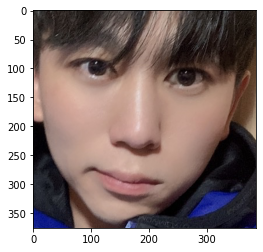

In [132]:
# 이미지 파일에서 얼굴 영역을 가져오는 함수
def get_cropped_face(image_file):
    try:
        image = face_recognition.load_image_file(image_file)
        face_locations = face_recognition.face_locations(image)
        a, b, c, d = face_locations[0]
        cropped_face = image[a:c,d:b,:]
    except:
        #print(image_file) #얼굴 인식이 안되는 사진 확인.
        cropped_face = 0
    
    return cropped_face

image_path = os.getenv('HOME')+'/aiffel/face_embedding/Jukcelebrity/정의경2.jpg'

cropped_face = get_cropped_face(image_path)
plt.imshow(cropped_face)

+ 얼굴 영역의 얼굴 임베딩벡터 구함

In [133]:
def get_face_embedding(face):
    try:
        return face_recognition.face_encodings(face)
    except:
        return 0

In [134]:
def get_face_embedding_dict(dir_path):
    file_list = os.listdir(dir_path)
    embedding_dict = {}
    
    for file in file_list:
        img_path = os.path.join(dir_path, file)
        face = get_cropped_face(img_path)
        embedding = get_face_embedding(face)
        try:
            if len(embedding) > 0:  
            # 얼굴영역 face가 제대로 detect되지 않으면  len(embedding)==0인 경우가 발생하므로 
            # os.path.splitext(file)[0]에는 이미지파일명에서 확장자를 제거한 이름이 담깁니다. 
                embedding_dict[os.path.splitext(file)[0]] = embedding[0]
        except:
            continue
    return embedding_dict

+ 딕셔너리를 이용해서 구한 임베딩벡터값 확인

In [135]:
embedding_dict = get_face_embedding_dict(dir_path)
embedding_dict['정의경2']

array([-0.06512986,  0.0287025 ,  0.00215496, -0.06741095, -0.08956254,
       -0.016928  , -0.06982516, -0.09363313,  0.13197291, -0.06711471,
        0.2402088 , -0.05199663, -0.23054647, -0.06158234, -0.08893428,
        0.18711677, -0.15291834, -0.14530511, -0.04742661,  0.04625918,
        0.12414702,  0.06449369,  0.01997562,  0.04919854, -0.150361  ,
       -0.31968564, -0.10555673, -0.07216462, -0.03483985, -0.05771422,
       -0.03308103,  0.02039256, -0.20541432, -0.01285318,  0.09344218,
        0.06095476, -0.00803187, -0.12468056,  0.15970485,  0.0051828 ,
       -0.34333277,  0.0675284 ,  0.09246625,  0.22595148,  0.12488921,
        0.00325338, -0.00623647, -0.2080906 ,  0.08656697, -0.14113362,
        0.08342849,  0.15548085,  0.04917886,  0.02160913,  0.00207788,
       -0.09886038,  0.03702624,  0.14514245, -0.16682564, -0.04076592,
        0.10152073, -0.01417524, -0.01672398, -0.12583356,  0.14256933,
        0.07841116, -0.12871329, -0.24734761,  0.11585904, -0.14

# 3. 사진들과의 비교

+ 먼저 나의 사진끼리 비교했을떄 벡터거리의 값 확인
 + 벡터 거리의 값이 0에 가까운거 보아하니 나쁘지 않은 결과를 도출한것을 볼 수 있다.

In [136]:
import numpy as np
def get_distance(name1, name2):
    return np.linalg.norm(embedding_dict[name1]-embedding_dict[name2], ord=2)
    #ord = 2로 L2 구현 1이면 L1
get_distance('정의경1', '정의경2')

0.38800264598119527

In [137]:
# name1과 name2의 거리를 비교하는 함수를 생성하되, 
# name1은 미리 지정하고, name2는 호출시에 인자로 받도록 합니다.
def get_sort_key_func(name1):
    def get_distance_from_name1(name2):
        return get_distance(name1, name2)
    return get_distance_from_name1

In [138]:
import pandas as pd

def get_nearest_face(name, top=5):
    sort_key_func = get_sort_key_func(name)
    sorted_faces = sorted(embedding_dict.items(), key=lambda x:sort_key_func(x[0]))
    rank,name,distance,idx = [],[],[],1
    
    for i in range(top+1):
        if i == 0 :   # 첫번째로 나오는 이름은 자기 자신일 것이므로 제외합시다. 
            continue
        else:
            rank.append(idx)
            name.append(sorted_faces[i][0])
            distance.append(sort_key_func(sorted_faces[i][0]))
            idx += 1
    data = {'Rank':rank, 'Name':name, 'Distance':distance}
    return pd.DataFrame(data)

In [139]:
get_nearest_face('정의경2')

,Rank,Name,Distance
0,1,지코,0.363519
1,2,정국,0.383270
2,3,정의경1,0.388003
3,4,박경,0.404591
4,5,케이,0.408110


In [140]:
get_nearest_face('정의경1')

,Rank,Name,Distance
0,1,정의경2,0.388003
1,2,꽈두룹,0.420088
2,3,박경,0.420417
3,4,지수,0.433053
4,5,트와이스사나,0.437659


# 4. 시각화

In [152]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def nearest_image(name):
    df = get_nearest_face(name)
    fig = plt.figure(figsize = (10,5))
    
    i=1
    for name in df['Name']:
        near_path = os.path.join(dir_path,name + '.jpg')
        img = mpimg.imread(near_path)
        ax=fig.add_subplot(1,6,i)
        plt.imshow(img)
        plt.axis("off")
        ax.set_title(i)
        i+=1
    
    plt.show()    

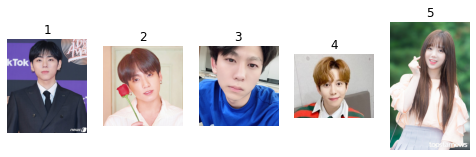

In [153]:
nearest_image('정의경2')

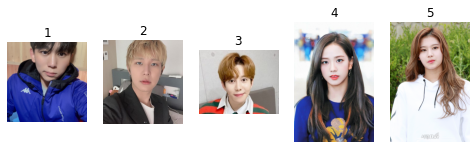

In [155]:
nearest_image('정의경1')

---
# 회고

1. 닮은꼴 순위, 이름, 임베딩 거리를 포함해서 Top-5 리스트를 pandas를 이용해서 표로 나타내어보았다.


2. 퍼실님이 제공해주신 연애인 사진과 나랑 닯았다고 들었던 연애인 박경,변요한을 넣어보았는데 임베딩거리 0.5이내의 연애인들이 몇몇있었다.


3. dataframe 으로 얻은 정보로 matplotlib으로 시각화로 나타내어보았다. 따로 추가한 박경이 있었고 나열해보니 다들 비슷한 부분의 얼굴이 있었다. 

얼굴이 인식이 안되어 오류나는 부분을 try exept로 제외해주는 부분에서 힘이 들었다.   
나의 사진들은 서로 비슷한 순위를 기록한것을 보니 나름 잘 찾아내는것같았다.
